Importing Packages

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Dense, Flatten, Dropout,
                                     GlobalAveragePooling2D, BatchNormalization,
                                     Activation, Multiply, MaxPooling2D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image



Loading Dataset and Data Preprocessing

In [ ]:
train_dir = "/content/drive/MyDrive/Forest Fire Detection/Dataset/train"
test_dir = "/content/drive/MyDrive/Forest Fire Detection/Dataset/test"

img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

print("Class Indices:", train_data.class_indices)


Found 2498 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Indices: {'fire': 0, 'non fire': 1}


Plotting the sample image along with their labels

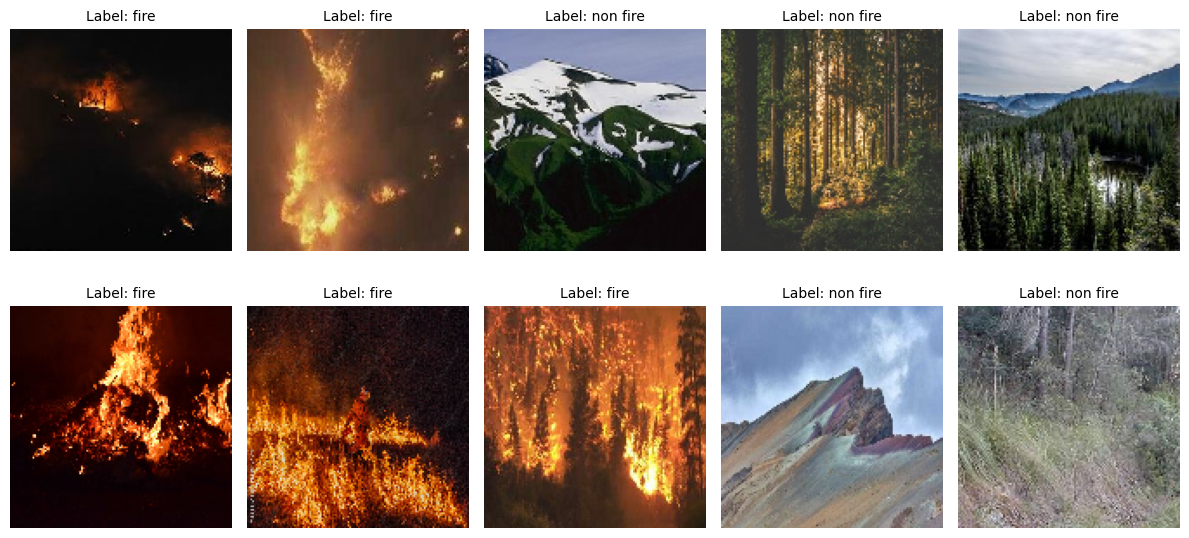

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_data)

class_labels = {v: k for k, v in train_data.class_indices.items()}

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {class_labels[int(labels[i])]}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


Build MSA-Net Model with SE Blocks

In [ ]:
from tensorflow.keras.layers import (Input, Conv2D, Dense, Flatten, Dropout,
                                     GlobalAveragePooling2D, BatchNormalization,
                                     Activation, Multiply, MaxPooling2D, Reshape)


def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]

    squeeze = GlobalAveragePooling2D()(input_tensor)
    excitation = Dense(channels // ratio, activation="relu")(squeeze)
    excitation = Dense(channels, activation="sigmoid")(excitation)

    excitation = Reshape((1, 1, channels))(excitation)
    return Multiply()([input_tensor, excitation])

def multi_scale_conv(input_tensor, filters):
    conv3 = Conv2D(filters, (3, 3), padding="same", activation="relu")(input_tensor)
    conv5 = Conv2D(filters, (5, 5), padding="same", activation="relu")(input_tensor)
    conv7 = Conv2D(filters, (7, 7), padding="same", activation="relu")(input_tensor)

    output = tf.keras.layers.Add()([conv3, conv5, conv7])
    output = BatchNormalization()(output)
    return output

def msa_net(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    x = multi_scale_conv(inputs, 64)
    x = se_block(x)

    x = multi_scale_conv(x, 128)
    x = se_block(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    return model

model = msa_net()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 64)   │          4,864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 64)   │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 128, 128, 64)   │              0 │ conv2d_6[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 64)   │            256 │ add_2[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ batch_normalization_2… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │            320 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 1, 64)       │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
│                           │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 128, 128, 128)  │        204,928 │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 128, 128, 128)  │        401,536 │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 128, 128, 128)  │              0 │ conv2d_9[0][0],        │
│                           │                        │                │ conv2d_10[0][0],       │
│                           │                        │                │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 134,918,221 (514.67 MB)

 Trainable params: 134,917,837 (514.67 MB)

 Non-trainable params: 384 (1.50 KB)

Training the Model with Early Stopping & Learning Rate Scheduling

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_data,
    epochs=100,
    validation_data=test_data,
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 975s 12s/step - accuracy: 0.7390 - loss: 30.4638 - val_accuracy: 0.8120 - val_loss: 10.8805 - learning_rate: 0.0010
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 746s 9s/step - accuracy: 0.8515 - loss: 5.8911 - val_accuracy: 0.7830 - val_loss: 11.0577 - learning_rate: 0.0010
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 743s 9s/step - accuracy: 0.8630 - loss: 1.8140 - val_accuracy: 0.8400 - val_loss: 6.7507 - learning_rate: 0.0010
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 738s 9s/step - accuracy: 0.8487 - loss: 0.5472 - val_accuracy: 0.8470 - val_loss: 4.3932 - learning_rate: 0.0010
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 740s 9s/step - accuracy: 0.8658 - loss: 0.4612 - val_accuracy: 0.8690 - val_loss: 1.5191 - learning_rate: 0.0010
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 739s 9s/step - accuracy: 0.8944 - loss: 0.3267 - val_accuracy: 0.9080 - val_loss: 0.3577 - learning_rate: 0.0010
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 740s 9s/step - accuracy: 0.9021 - loss: 0.211

Saving the model

In [ ]:
model.save("/content/drive/MyDrive/Forest Fire Detection/model.h5")

Saving the history of the model

In [ ]:
import json

history_dict = history.history

with open("/content/drive/MyDrive/Forest Fire Detection/model_history.json", "w") as f:
    json.dump(history_dict, f)

print("Training history saved successfully!")


Training history saved successfully!


Loading the Saved Model

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/content/drive/MyDrive/Forest Fire Detection/model.h5")
print("Model loaded successfully!")


Model loaded successfully!


Loading the History

In [ ]:
import json

with open("/content/drive/MyDrive/Forest Fire Detection/model_history.json", "r") as f:
    loaded_history = json.load(f)

print("History loaded successfully!")


History loaded successfully!


Printing the Test Accuracy and Loss

In [ ]:
test_loss, test_acc = loaded_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 335s 11s/step - accuracy: 0.9751 - loss: 0.1035
Test Accuracy: 96.10%
Test Loss: 0.1537


Plotting the Training and Validataion Accuracy Curves

Text(0.5, 1.0, 'Training vs Validation Accuracy')

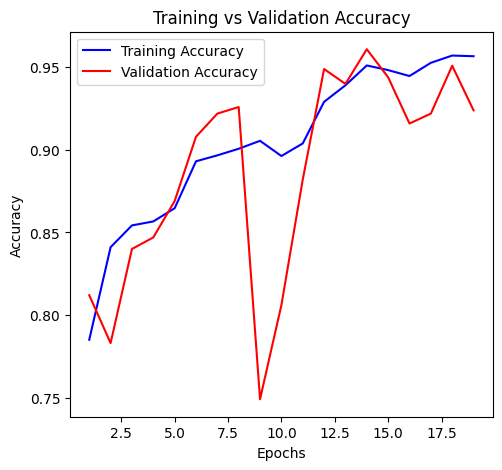

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(loaded_history["loss"]) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loaded_history["accuracy"], "b", label="Training Accuracy")
plt.plot(epochs, loaded_history["val_accuracy"], "r", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")


Plotting the Training and Testing Loss curve

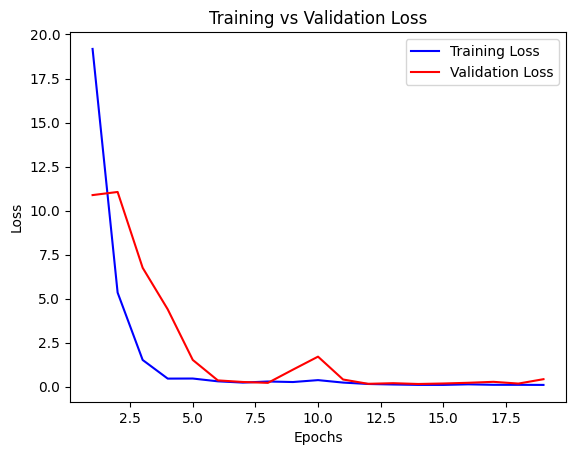

In [ ]:

plt.plot(epochs, loaded_history["loss"], "b", label="Training Loss")
plt.plot(epochs, loaded_history["val_loss"], "r", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


Printing the Classification Report

In [ ]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

true_labels = test_data.classes

predictions = loaded_model.predict(test_data)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

print("\nClassification Report:\n", classification_report(true_labels, predicted_classes, target_names=["Fire", "Non-Fire"]))



32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step

Classification Report:
               precision    recall  f1-score   support

        Fire       0.95      0.98      0.96       500
    Non-Fire       0.98      0.94      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



Printing the Confusion Matrix

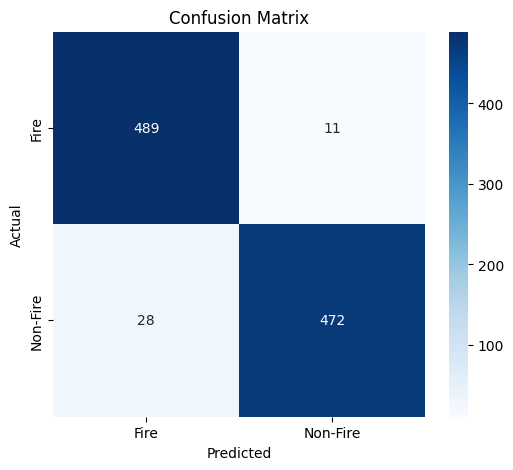

In [ ]:

import seaborn as sns

cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fire", "Non-Fire"], yticklabels=["Fire", "Non-Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Predicting class for the test sample

In [ ]:

class_labels = {0: "Fire", 1: "Non-Fire"}

def predict_image(img_path, img_size=(128, 128)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = loaded_model.predict(img_array)[0][0]

    predicted_class = 1 if prediction > 0.5 else 0
    predicted_label = class_labels[predicted_class]

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}", color="green" if predicted_class == 0 else "blue")

    plt.axis("off")
    plt.show()

    print("Predicted Label:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


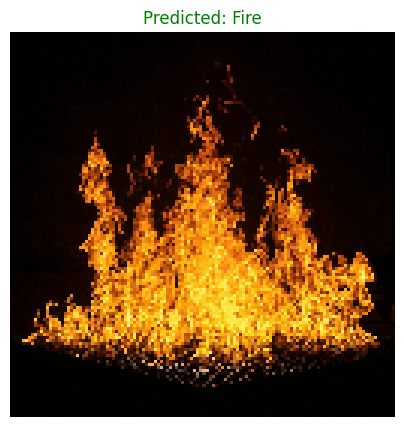

Predicted Label: Fire


In [ ]:
sample_image_path = "/content/drive/MyDrive/fire.jpg"
predict_image(sample_image_path)


Plotting the Actual and Predicted Class for 5 sample Test images

In [ ]:
import os

test_image_dir = "/content/drive/MyDrive/Forest Fire Detection/Dataset/test"

fire_images = os.listdir(os.path.join(test_image_dir, "fire"))[:5]
non_fire_images = os.listdir(os.path.join(test_image_dir, "non fire"))[:5]

print("Fire Images:", fire_images)
print("Non-Fire Images:", non_fire_images)


Fire Images: ['Fire (37).jpeg', 'Fire (204).png', 'Fire (37).png', 'Fire (41).jpeg', 'Fire (38).jpg']
Non-Fire Images: ['0BC55VR9BNC2.jpg', '1AK4TZQ6OGUY - Copy.jpg', '0UPDPZ1BZDOC.jpg', '0SUMMO61WLH5.jpg', '1A4Y75CC6NWP.jpg']


In [ ]:
def load_and_preprocess_image(img_path, img_size=(128, 128)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


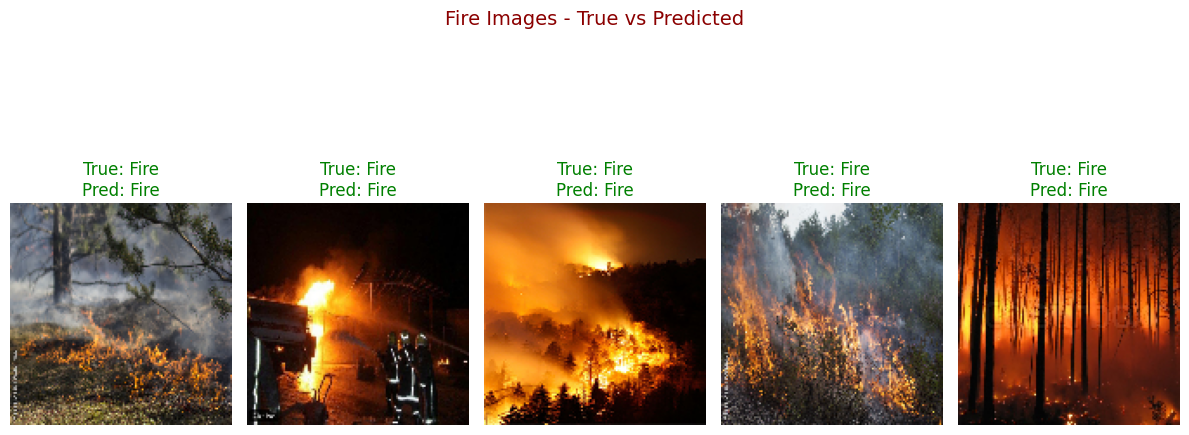

In [ ]:
plt.figure(figsize=(12, 6))
for i, img_name in enumerate(fire_images):
    img_path = os.path.join(test_image_dir, "fire", img_name)
    img_array, img = load_and_preprocess_image(img_path)

    prediction = loaded_model.predict(img_array)[0][0]
    predicted_label = "Non-Fire" if prediction > 0.5 else "Fire"

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: Fire\nPred: {predicted_label}",
              color="green" if predicted_label == "Fire" else "red")
    plt.axis("off")

plt.suptitle("Fire Images - True vs Predicted", fontsize=14, color="darkred")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


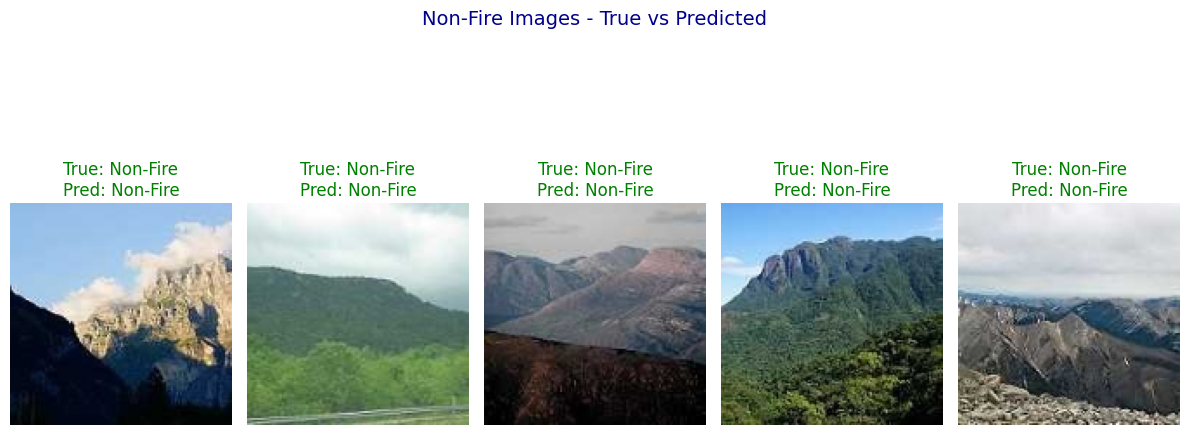

In [ ]:
plt.figure(figsize=(12, 6))
for i, img_name in enumerate(non_fire_images):
    img_path = os.path.join(test_image_dir, "non fire", img_name)
    img_array, img = load_and_preprocess_image(img_path)

    prediction = loaded_model.predict(img_array)[0][0]
    predicted_label = "Non-Fire" if prediction > 0.5 else "Fire"

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: Non-Fire\nPred: {predicted_label}",
              color="green" if predicted_label == "Non-Fire" else "red")
    plt.axis("off")

plt.suptitle("Non-Fire Images - True vs Predicted", fontsize=14, color="darkblue")
plt.tight_layout()
plt.show()
